1000



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.066648
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.457479
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.193988
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.960490
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.927827
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.832355
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.968486
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.900385
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.826668
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.839929
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.685176
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.728690
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.579701
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.637206
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.449596
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.491842
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.007892
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.637260
Train Epoch: 1 [12160/6

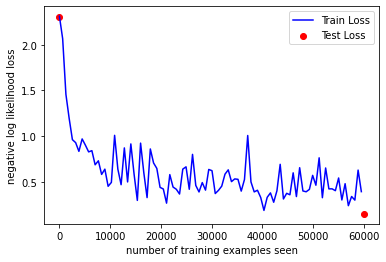

"continued_network = Net()\ncontinued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)\n \nnetwork_state_dict = torch.load('model.pth')\ncontinued_network.load_state_dict(network_state_dict)\noptimizer_state_dict = torch.load('optimizer.pth')\ncontinued_optimizer.load_state_dict(optimizer_state_dict)\n \n# 注意不要注释前面的“for epoch in range(1, n_epochs + 1):”部分，\n# 不然报错：x and y must be the same size\n# 为什么是“4”开始呢，因为n_epochs=3，上面用了[1, n_epochs + 1)\nfor i in range(4, 9):\n    test_counter.append(i*len(train_loader.dataset))\n    train(i)\n    test()\n \nfig = plt.figure()\nplt.plot(train_counter, train_losses, color='blue')\nplt.scatter(test_counter, test_losses, color='red')\nplt.legend(['Train Loss', 'Test Loss'], loc='upper right')\nplt.xlabel('number of training examples seen')\nplt.ylabel('negative log likelihood loss')\nplt.show()"

In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
 
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)
 
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

#test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
 
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_targets))
# print(example_data.shape)
 
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()
 
 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
network = Net()
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
 
train_losses = []
train_counter = []
test_losses = []
test_counter1 = [i * len(train_loader.dataset) for i in range(2)]
test_counter2 = [i * len(train_loader.dataset) for i in range(3)]
test_counter3 = [i * len(train_loader.dataset) for i in range(9)]
pred_all=[]
target_all=[]
test_loss_average=[]
test_loss_all=0
 
 
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
 
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            #print(len(pred))
            #print(len(target.data))
            #predict_model(pred,target.data)
            pred_all.append(pred)
            target_all.append(target.data)
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    #test_loss_all += test_loss
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
 
def predict_model(y_predicted,ytest):
    #根据预测结果和真实结果计算混淆矩阵
    con1=confusion_matrix(ytest, y_predicted)
    print(con1)
    print("精确度")
    print(precision_score(ytest,y_predicted,average='macro'))
    print("召回率")
    print(recall_score(ytest,y_predicted,average='macro'))
    print("F1值")
    print(f1_score(ytest,y_predicted,average='macro'))
    
#画损失函数曲线
def draw(train_counter,train_losses,test_counter,test_losses):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()

test()
#test_loss_average[0] = test_loss_all /  10000
#test_loss_all
#print(np.array(target_all))
"""pred_all=torch.stack(pred_all, dim=0)
target_all=torch.stack(target_all, dim=0)
target_all=target_all.numpy()
pred_all=pred_all.numpy()
target_all=[i for arr in target_all for i in arr]
pred_all=[i for arr in pred_all for i in arr]
#print(target_all)
#print([i for arr in target_all for i in arr])
#print(len(target_all))
#print(pred_all)
predict_model(pred_all,target_all)"""
train(1) 
test()  # 不加这个，后面画图就会报错：x and y must be the same size
draw(train_counter,train_losses,test_counter1,test_losses)

for epoch in range(2, n_epochs + 1):
    train(epoch)
    pred_all=[]
    target_all=[]
    test()

draw(train_counter,train_losses,test_counter2,test_losses)

"""for parameters in network.parameters():
    print(parameters)

print("################################################")
for name, parameters in network.named_parameters():
    print(name, ':', parameters.size())"""


pred_all=torch.stack(pred_all, dim=0)
target_all=torch.stack(target_all, dim=0)
target_all=target_all.numpy()
pred_all=pred_all.numpy()
target_all=[i for arr in target_all for i in arr]
pred_all=[i for arr in pred_all for i in arr]
print(len(pred_all))
predict_model(pred_all,target_all)

for epoch in range(3, 9):
    train(epoch)
    pred_all=[]
    target_all=[]
    test()
    
"""for parameters in network.parameters():
    print(parameters)

print("################################################")
for name, parameters in network.named_parameters():
    print(name, ':', parameters.size())"""
   
draw(train_counter,train_losses,test_counter3,test_losses)


pred_all=torch.stack(pred_all, dim=0)
target_all=torch.stack(target_all, dim=0)
target_all=target_all.numpy()
pred_all=pred_all.numpy()
target_all=[i for arr in target_all for i in arr]
pred_all=[i for arr in pred_all for i in arr]
predict_model(pred_all,target_all)
